# Mixed Effects Random Forests (MERF)

#### Running mixed effects random forests (MERF) to investigate the relationship between a predictor and a target over time using synthetic data intended to mimic the vitarenal data

Power calculation (based on repeated measures ANOVA, N=24, 4 time levels, and 2 equal sized groups, with 80% power and 5% alpha) shows that effects at the higher boundary of small effect sizes and the lower boundary of medium sized effects of Cohen’s d=.50-.55 (ƞ2=.07) can be reliably detected. This calculation allows for the planned linear mixed-model within-between interaction analyses, described at par. 8.3. For the analyses of main effects on the main endpoint/primary outcome (decrease over time on both cognitive biases within whole sample) the power with a N=24 sample size is considerably larger. Previous studies from our team among healthy volunteers with fatigue complaints showed similar effect sizes after less intensive single-session CBM (Pieterse & Bode, 2018). As LMM analyses can account for missing values effectively, partial missingness of datapoints is allowed and does not necessarily affect this power calculation.

- N = 24,
- Repeated measures = 4
- Groups = 2

In [1]:
2 * 4 * 24

192

In [2]:
from pymer4 import Lmer, simulate_lmm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from local_MERF import MERF
# from jmspack.ml_utils import optimize_model
# from jmspack.utils import silence_stdout
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from matplotlib.lines import Line2D
import session_info
import pingouin as pg

In [3]:
session_info.show(write_req_file=False)

In [4]:
if "jms_style_sheet" in plt.style.available:
    plt.style.use("jms_style_sheet")

In [5]:
number_observations = 4 # amount of observations per group (i.e. user_id)
number_predictors = 5
number_groups = 40 # amount of groups (i.e. user_id)

df, blups, coefficient = simulate_lmm(num_obs=number_observations,
    num_coef=number_predictors,
    num_grps=number_groups,
    coef_vals=None,
    corrs=None,
    grp_sigmas=0.25,
    mus=0.0,
    sigmas=1.0,
    noise_params=(0, 2),
    family='gaussian',
    seed=69420)

df = (df.assign(m00_name= lambda x: np.tile(["m00", "m03", "m06", "m09"], number_groups))
      .assign(diagnosis = np.repeat([0, 1], int(df.shape[0]/2)))
      .rename(columns={"Group": "user_id"}, inplace=False)
      .assign(user_id=lambda x: x["user_id"].astype(int))
      )

In [6]:
coefficient

array([0.53109224, 0.35676397, 0.51311614, 0.32530468, 0.45724967,
       0.01407327])

In [7]:
display(df.head()), df.shape

,DV,IV1,IV2,IV3,IV4,IV5,user_id,m00_name,diagnosis
0,-0.176284,-0.631297,-1.545416,0.551350,0.465951,1.825298,1,m00,0
1,5.297406,-0.953989,1.068107,-0.375538,-0.775013,1.870303,1,m03,0
2,1.694839,-1.404839,2.835310,-0.413594,-1.253913,-1.061551,1,m06,0
3,2.079718,-0.369729,-0.014778,0.255887,-0.590729,0.608351,1,m09,0
4,3.061051,0.047046,0.517653,1.551487,0.089594,1.478871,2,m00,0


(None, (160, 9))

In [8]:
predictor_list = df.filter(regex="IV").columns.tolist()[-2:4]

# df[predictor_list] = df[predictor_list].mask(np.random.random(df[predictor_list].shape) < .025)

In [9]:
target = "DV"
grp = "user_id"

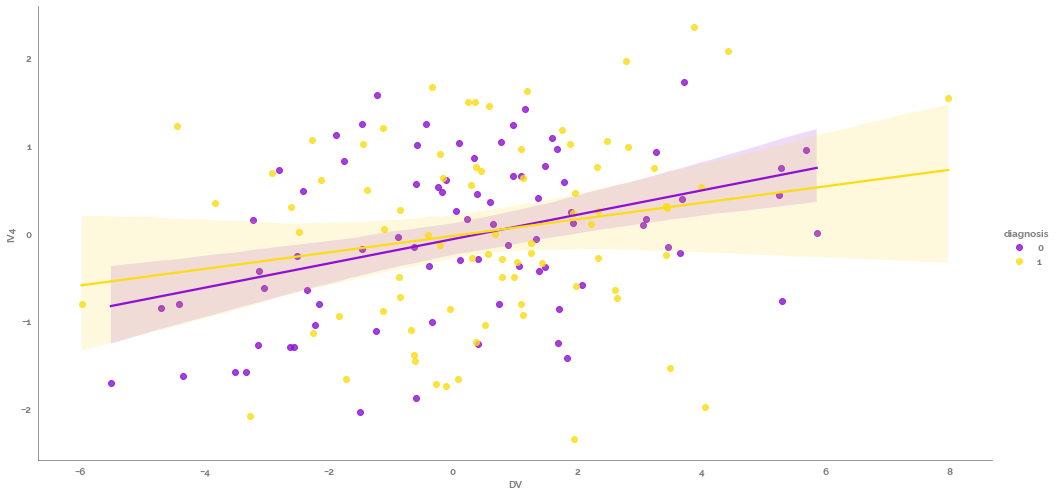

In [10]:
_ = sns.lmplot(data=df, x=target, y=predictor_list[0], hue="diagnosis", height=7, aspect=2)

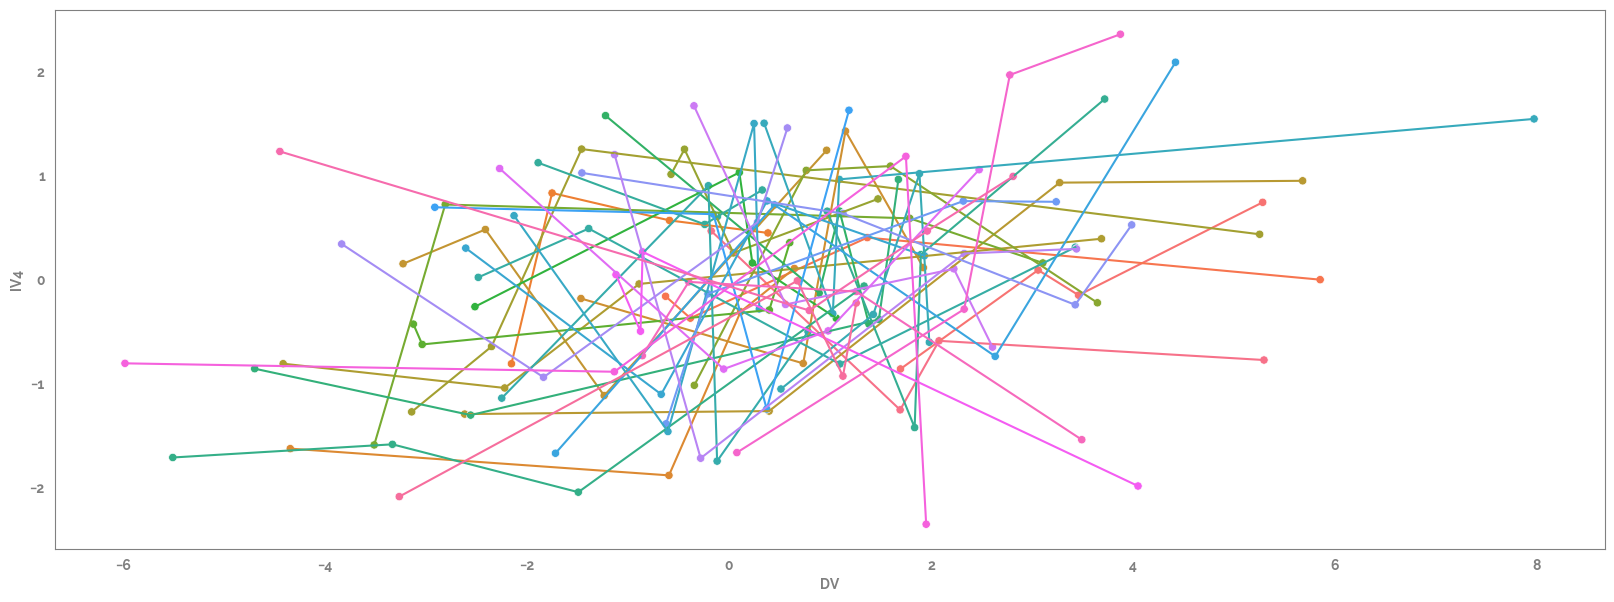

In [11]:
_ = plt.figure(figsize=(20, 7))
_ = sns.lineplot(data=df.assign(user_id=lambda x: x[grp].astype("category")), x=target, y=predictor_list[0], hue=grp, legend=False)
_ = sns.scatterplot(data=df.assign(user_id=lambda x: x[grp].astype("category")), x=target, y=predictor_list[0], hue=grp, legend=False)

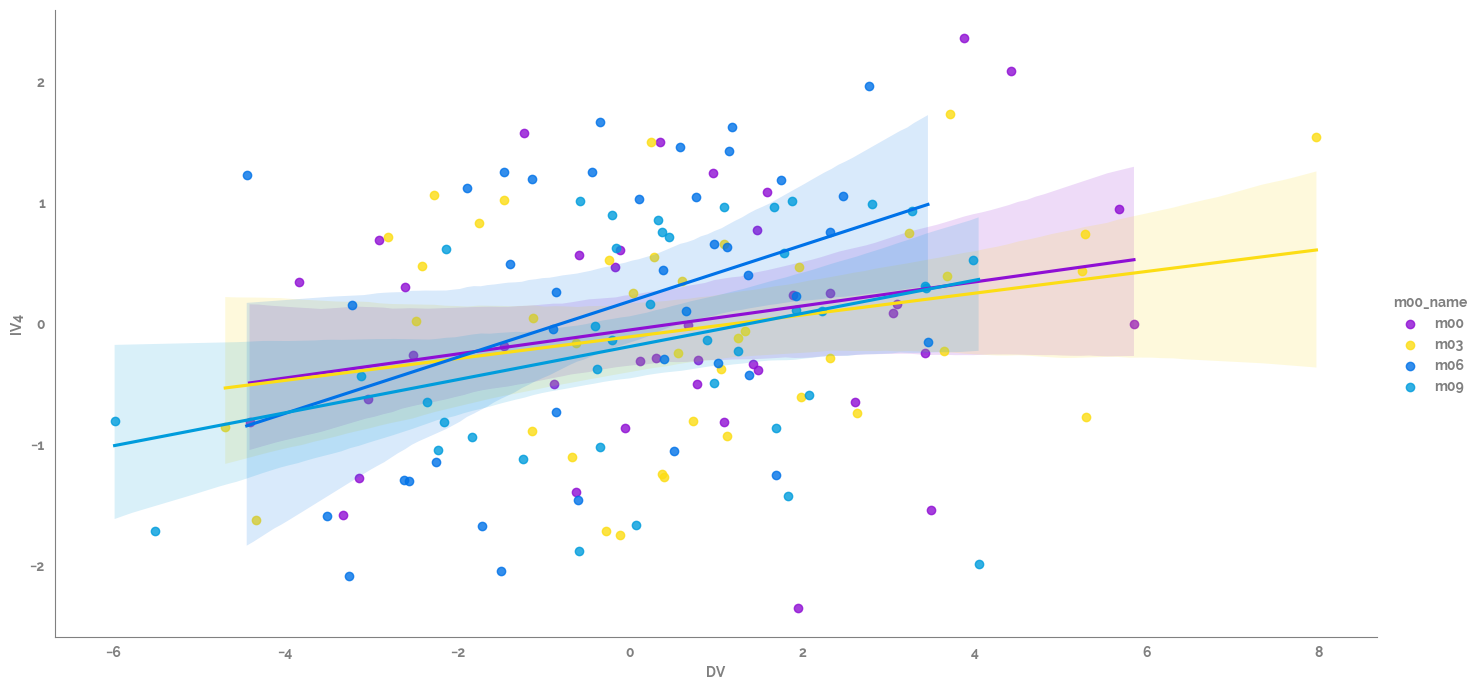

In [12]:
_ = sns.lmplot(data=df, x=target, y=predictor_list[0], hue="m00_name", height=7, aspect=2)

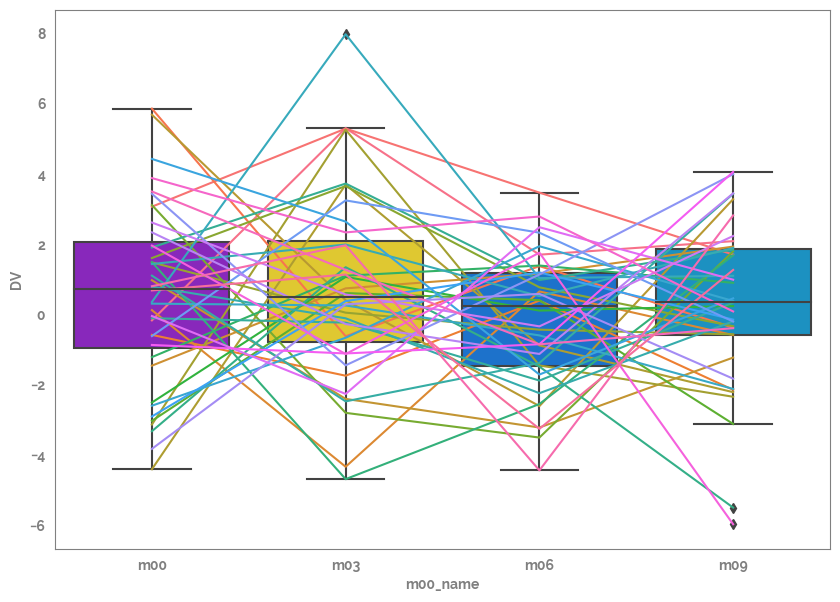

In [13]:
_ = plt.figure(figsize=(10, 7))
_ = sns.boxplot(data=df, x="m00_name", y=target)
_ = sns.lineplot(data=df.assign(user_id=lambda x: x[grp].astype("category")), x="m00_name", y=target, hue=grp, legend=False)

## Specify the predictor list, target and group

### Create train_test and hold out users

In [14]:
hold_out_users = df.sample(n=5, random_state=69420)["user_id"].unique().tolist()
train_test_users = df[~df['user_id'].isin(hold_out_users)]["user_id"].unique().tolist()

In [15]:
X = df.loc[df["user_id"].isin(train_test_users), predictor_list + [grp]]
y = df.loc[df["user_id"].isin(train_test_users), target]

hold_X = df.loc[df["user_id"].isin(hold_out_users), predictor_list + [grp]]
hold_y = df.loc[df["user_id"].isin(hold_out_users), target]

In [16]:
X_train = X.sample(frac=0.8, random_state=42)
X_test = X.drop(X_train.index, axis=0)
y_train = y.loc[X_train.index]
y_test = y.drop(X_train.index, axis=0)

In [17]:
print(X_train.shape); print(y_train.shape); print(X_test.shape); print(y_test.shape); print(hold_X.shape); print(hold_y.shape)

(112, 2)
(112,)
(28, 2)
(28,)
(20, 2)
(20,)


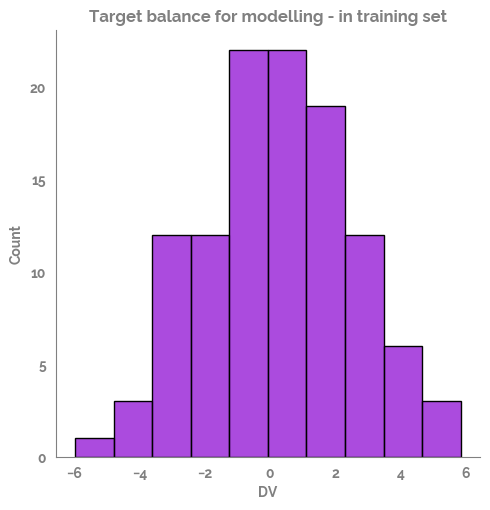

In [18]:
_ = sns.displot(x=y_train, bins=10)
_ = plt.title("Target balance for modelling - in training set")

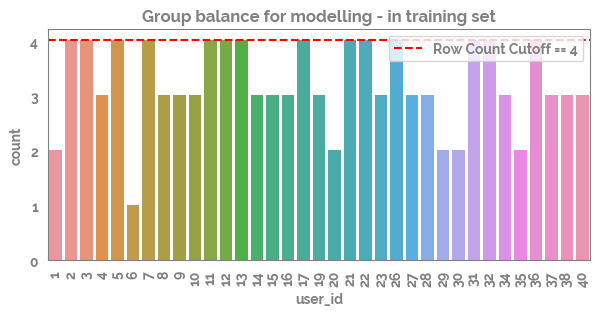

In [19]:
_ = plt.figure(figsize=(7,3))
_ = sns.countplot(x=X_train[grp])
_ = plt.title("Group balance for modelling - in training set")
cutoff = 4
_ = plt.axhline(cutoff, c="red",ls="--", label=f"Row Count Cutoff == {cutoff}")
_ = plt.legend()
_ = plt.xticks(rotation=90)

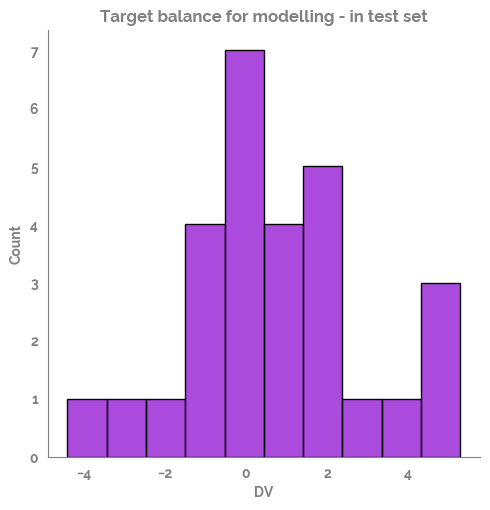

In [20]:
# _ = plt.figure(figsize=(30,5))
_ = sns.displot(x=y_test, bins=10)
_ = plt.title("Target balance for modelling - in test set")

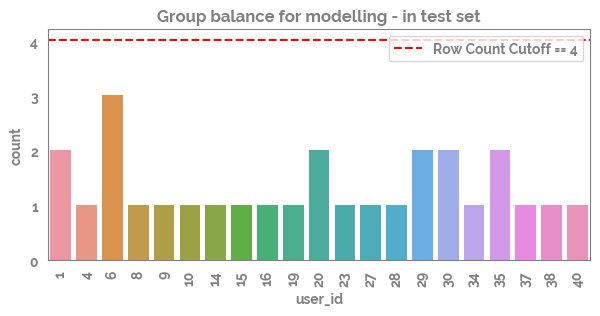

In [21]:
_ = plt.figure(figsize=(7,3))
_ = sns.countplot(x=X_test[grp])
_ = plt.title("Group balance for modelling - in test set")
cutoff = 4
_ = plt.axhline(cutoff, c="red", ls="--", label=f"Row Count Cutoff == {cutoff}")
_ = plt.legend()
_ = plt.xticks(rotation=90)
_ = plt.show()

In [22]:
tmp = X_train.apply(lambda x: x.nunique()).sort_values()
tmp

user_id     35
IV4        112
dtype: int64

In [23]:
n_it = 100 # specify the maximum amount of iterations you would like the MERF to use during expectation–maximization (EM)
rf_params={"n_estimators": 300, "criterion": "squared_error", "max_features": "sqrt", "oob_score": True}
merf = MERF(n_estimators=300, gll_early_stop_threshold=0.001, max_iterations=n_it, rf_params=rf_params)
_ = merf.fit(X=X_train, Z=np.ones((len(X_train), 1)), clusters=X_train[grp], y=y_train)
y_pred = merf.predict(X=X_test, Z=np.ones((len(X_test), 1)), clusters=X_test[grp])

In [24]:
pred_test_df=pd.DataFrame({"y_pred": y_pred, target: y_test, 'user_id': X_test['user_id']})
# pred_test_df = pred_test_df.groupby('user_id').mean()
merf_cors = pg.corr(pred_test_df["y_pred"], pred_test_df[target])
merf_cors

,n,r,CI95%,p-val,BF10,power
pearson,28,0.378408,"[0.01, 0.66]",0.047079,1.533,0.524503


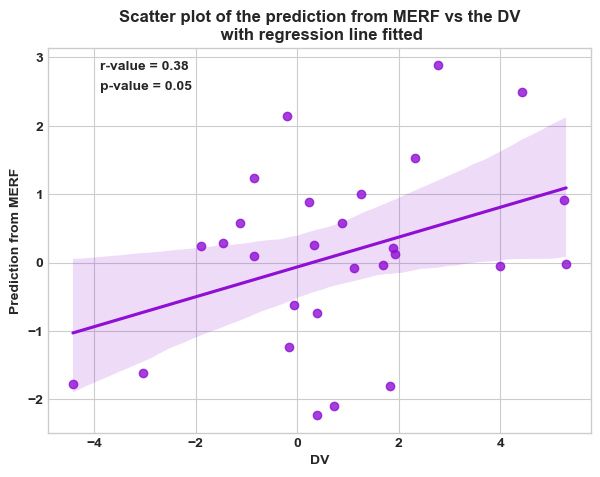

In [25]:
from matplotlib.lines import Line2D
plt.style.use('seaborn-whitegrid')
legend_elements = [Line2D([0], [0], marker="", color="k", label=f"r-value = {np.round(merf_cors['r'].iat[0],2)}", linestyle="none", ),
                  Line2D([0], [0], marker="", color="k", label=f"p-value = {np.round(merf_cors['p-val'].iat[0],2)}", linestyle="none", )]
fig, ax = plt.subplots(figsize=(7,5))
sns.regplot(x=target, y="y_pred", data=pred_test_df).\
set_title(f"Scatter plot of the prediction from MERF vs the {target}\n with regression line fitted")
_ = ax.legend(handles=legend_elements)
plt.xlabel(target)
plt.ylabel(f"Prediction from MERF")
plt.show()

In [26]:
user_id_min=pred_test_df.index.min()
user_id_max=pred_test_df.index.max()

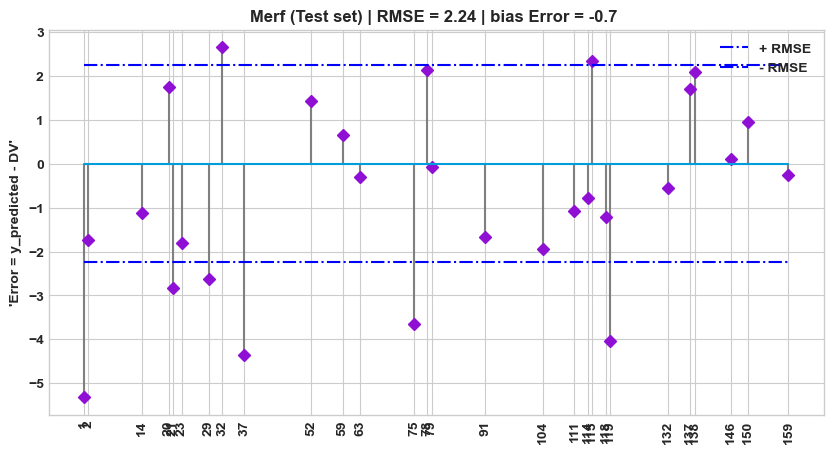

In [27]:
df_test=pred_test_df
# plt.style.use('ggplot')
plt.figure(figsize=(10,5))
plt.title(f"Merf (Test set) | RMSE = {round(np.sqrt(mean_squared_error(df_test['y_pred'], df_test[target])),2)} | bias Error = { round(np.mean(df_test['y_pred'] - df_test[target]), 2)} ")
plt.stem(df_test.index, df_test['y_pred'] - df_test[target], use_line_collection=True, linefmt='grey', markerfmt='D')
plt.hlines(y=round(np.sqrt(mean_squared_error(df_test['y_pred'], df_test[target])),2), colors='b', linestyles='-.', label='+ RMSE', xmin = user_id_min, xmax = user_id_max) 
plt.hlines(y=round(-np.sqrt(mean_squared_error(df_test['y_pred'], df_test[target])),2), colors='b', linestyles='-.', label='- RMSE', xmin = user_id_min, xmax = user_id_max) 
plt.xticks(rotation=90, ticks=df_test.index)
plt.ylabel(f"'Error = y_predicted - {target}'")
# plt.ylim([-.5,.6])
plt.legend()
_ = plt.show()

## Hold out set

In [28]:
y_pred = merf.predict(X=hold_X, Z=np.ones((len(hold_X), 1)), clusters=hold_X[grp])

In [29]:
pred_test_df=pd.DataFrame({"y_pred": y_pred, target: hold_y, grp: hold_X[grp]})
# pred_test_df = pred_test_df.groupby(grp).mean()
merf_cors = pg.corr(pred_test_df["y_pred"], pred_test_df[target])
merf_cors

,n,r,CI95%,p-val,BF10,power
pearson,20,0.511412,"[0.09, 0.78]",0.021181,3.31,0.661748


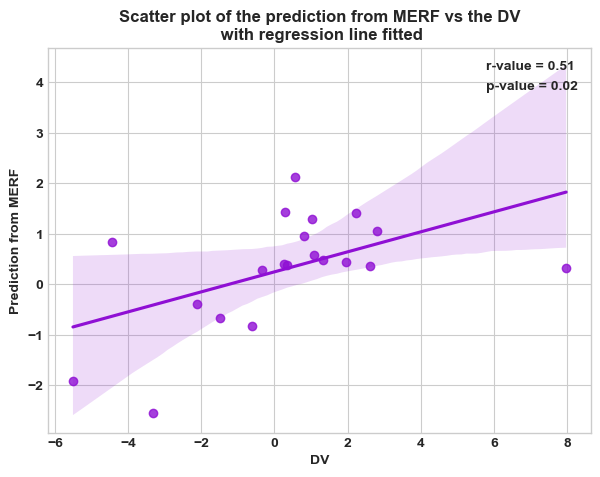

In [30]:
plt.style.use('seaborn-whitegrid')
legend_elements = [Line2D([0], [0], marker="", color="k", label=f"r-value = {np.round(merf_cors['r'].iat[0],2)}", linestyle="none", ),
                  Line2D([0], [0], marker="", color="k", label=f"p-value = {np.round(merf_cors['p-val'].iat[0],2)}", linestyle="none", )]
fig, ax = plt.subplots(figsize=(7,5))
sns.regplot(x=target, y="y_pred", data=pred_test_df).\
set_title(f"Scatter plot of the prediction from MERF vs the {target}\n with regression line fitted")
_ = ax.legend(handles=legend_elements)
plt.xlabel(target)
plt.ylabel(f"Prediction from MERF")
plt.show()

In [31]:
user_id_min=pred_test_df.index.min()
user_id_max=pred_test_df.index.max()

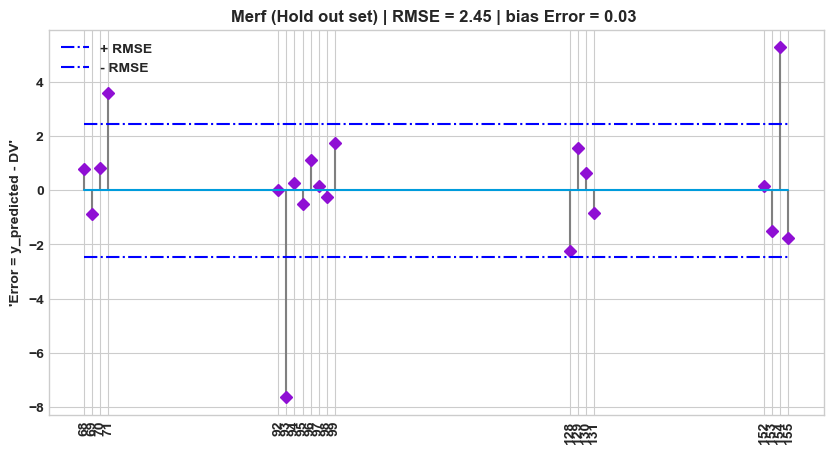

In [32]:
df_test=pred_test_df
# plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.title(f"Merf (Hold out set) | RMSE = {round(np.sqrt(mean_squared_error(df_test['y_pred'], df_test[target])),2)} | bias Error = { round(np.mean(df_test['y_pred'] - df_test[target]), 2)} ")
plt.stem(df_test.index, df_test['y_pred'] - df_test[target], use_line_collection=True, linefmt='grey', markerfmt='D')
plt.hlines(y=round(np.sqrt(mean_squared_error(df_test['y_pred'], df_test[target])),2), colors='b', linestyles='-.', label='+ RMSE', xmin = user_id_min, xmax = user_id_max) 
plt.hlines(y=round(-np.sqrt(mean_squared_error(df_test['y_pred'], df_test[target])),2), colors='b', linestyles='-.', label='- RMSE', xmin = user_id_min, xmax = user_id_max) 
plt.xticks(rotation=90, ticks=df_test.index)
plt.ylabel(f"'Error = y_predicted - {target}'")
# plt.ylim([-.5,.6])
plt.legend()
_ = plt.show()